# ADNIMERGE Dataset

This notebook forms part of the Appendices, provides supplementary materials that are essential for understanding my research, but would otherwise crowd the main body of my report. I used this notebook to present detailed data, methodologies, and analyses that support my research findings without disrupting the flow of the report's narrative. Specifically, this appendix/ notebook contain:

- Detailed data pre-processing steps, including steps for handling missing data, encoding, and normalization for the ADNI dataset, which is crucial for reproducibility but may be too granular for the main report.

- Visualizations and correlation analyses, providing comprehensive graphical representations and statistical analyses that offer deeper insights into the data. 

- Feature engineering details, elaborating on the selection and optimisation of features for model learning -underpinning the models' performance and interpretability.

- Hyper-parameter tuning and model evaluation metrics, with detailed tables and charts documenting the process of tuning machine learning models and their performance across various metrics.

- SHAP value analyses and bias mitigation strategies, offering in-depth discussions and visualizations related to model interpretability and fairness, critical for understanding the models' decision-making processes.

- Detailed code, with comments, for the relevant phases of project work.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries

In [ ]:
import os
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import glob
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
%matplotlib inline

## Import Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Transfer/ADNIMERGE_11Dec2023.csv")
data.head()

<ipython-input-3-dcc5f6ce64bf>:1: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Transfer/ADNIMERGE_11Dec2023.csv")


,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,1.33615,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.000000,0.00000,0,0,2023-07-07 04:59:40.0
2,3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.498289,5.96721,6,6,2023-07-07 04:59:40.0
3,3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,0.999316,11.96720,12,12,2023-07-07 04:59:40.0
4,3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,...,22.83,1.10860,NaN,NaN,NaN,1.998630,23.93440,24,24,2023-07-07 04:59:40.0


## Extract Required Features

In [ ]:
# Store the names of selected columns
selected_column_names = ["AGE", "PTGENDER", "PTEDUCAT", "DX_bl", "APOE4", "FDG", "PIB", "AV45", "FBB", "MMSE", "RAVLT_immediate", "RAVLT_learning", "RAVLT_forgetting", "RAVLT_perc_forgetting", "DX"]

# Combine selected columns with their names
data = data[selected_column_names]

data.head()

,AGE,PTGENDER,PTEDUCAT,DX_bl,APOE4,FDG,PIB,AV45,FBB,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,DX
0,74.3,Male,16,CN,0.0,1.33615,NaN,NaN,NaN,28.0,44.0,4.0,6.0,54.5455,CN
1,81.3,Male,18,AD,1.0,1.10860,NaN,NaN,NaN,20.0,22.0,1.0,4.0,100.0000,Dementia
2,81.3,Male,18,AD,1.0,1.07796,NaN,NaN,NaN,24.0,19.0,2.0,6.0,100.0000,Dementia
3,81.3,Male,18,AD,1.0,1.11626,NaN,NaN,NaN,17.0,31.0,2.0,7.0,100.0000,Dementia
4,81.3,Male,18,AD,1.0,1.06134,NaN,NaN,NaN,19.0,23.0,1.0,5.0,100.0000,Dementia


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16421 entries, 0 to 16420
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AGE                    16412 non-null  float64
 1   PTGENDER               16421 non-null  object 
 2   PTEDUCAT               16421 non-null  int64  
 3   DX_bl                  16410 non-null  object 
 4   APOE4                  16056 non-null  float64
 5   FDG                    3693 non-null   float64
 6   PIB                    223 non-null    float64
 7   AV45                   3080 non-null   float64
 8   FBB                    513 non-null    float64
 9   MMSE                   11469 non-null  float64
 10  RAVLT_immediate        11346 non-null  float64
 11  RAVLT_learning         11347 non-null  float64
 12  RAVLT_forgetting       11315 non-null  float64
 13  RAVLT_perc_forgetting  11242 non-null  float64
 14  DX                     11458 non-null  object 
dtypes:

In [ ]:
data["MMSE"].describe()

count    11469.000000
mean        26.787340
std          3.882297
min          0.000000
25%         25.000000
50%         28.000000
75%         29.000000
max         30.000000
Name: MMSE, dtype: float64

## Handling Missing Values & Redundancy

In [ ]:
# Calculate the percentage of missing values for each column
missing_percentage = (data.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
})

# Sort the DataFrame by missing percentage in descending order
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)
missing_df

,Column,Missing Percentage
0,PIB,98.64
1,FBB,96.88
2,AV45,81.24
3,FDG,77.51
4,RAVLT_perc_forgetting,31.54
5,RAVLT_forgetting,31.09
6,RAVLT_immediate,30.91
7,RAVLT_learning,30.90
8,DX,30.22
9,MMSE,30.16


In [ ]:
# Delete the features with missing values percentages exceed the threshold
threshold_percentage = 50

# Identify columns with missing percentages greater than the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold_percentage].index

# Drop columns with high missing percentages
data = data.drop(columns=columns_to_drop)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16421 entries, 0 to 16420
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AGE                    16412 non-null  float64
 1   PTGENDER               16421 non-null  object 
 2   PTEDUCAT               16421 non-null  int64  
 3   DX_bl                  16410 non-null  object 
 4   APOE4                  16056 non-null  float64
 5   MMSE                   11469 non-null  float64
 6   RAVLT_immediate        11346 non-null  float64
 7   RAVLT_learning         11347 non-null  float64
 8   RAVLT_forgetting       11315 non-null  float64
 9   RAVLT_perc_forgetting  11242 non-null  float64
 10  DX                     11458 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 1.4+ MB


In [ ]:
# Drop duplicate rows and keep the first occurrence
data.drop_duplicates(inplace=True)

# Handle the missing values
# Iterate over each column
for column in data.columns:
    # Check if the column is categorical
    if data[column].dtype == 'object':
        # For categorical columns, fill missing values with the mode of the column
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        # For numerical columns, fill missing values with the mean of the column
        data[column].fillna(data[column].mean(), inplace=True)

# Calculate the new percentage of missing values
missing_percentage = (data.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
})

# Sort the DataFrame by missing percentage in descending order
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)
missing_df

<ipython-input-9-9a455f11f3aa>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)
<ipython-input-9-9a455f11f3aa>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

,Column,Missing Percentage
0,AGE,0.0
1,PTGENDER,0.0
2,PTEDUCAT,0.0
3,DX_bl,0.0
4,APOE4,0.0
5,MMSE,0.0
6,RAVLT_immediate,0.0
7,RAVLT_learning,0.0
8,RAVLT_forgetting,0.0
9,RAVLT_perc_forgetting,0.0


## Age & Gender Distribution

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


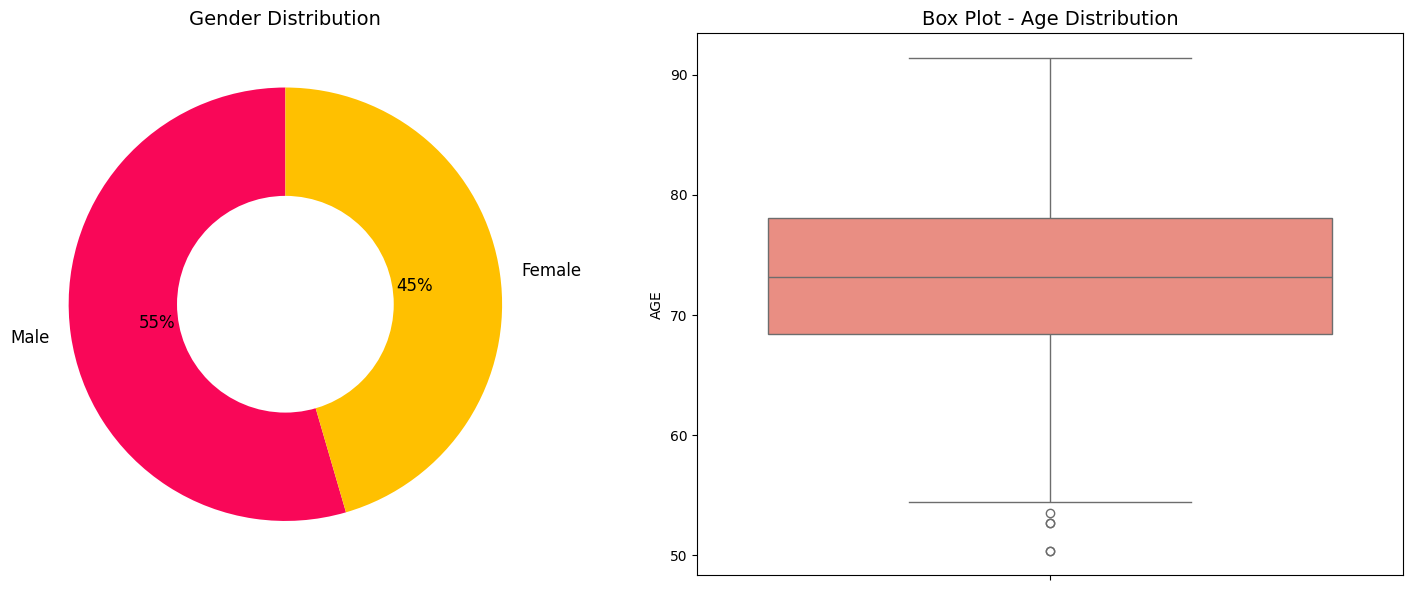

In [ ]:
# Convert 'Age' column to numeric
data['AGE'] = pd.to_numeric(data['AGE'], errors='coerce')
gender_counts = data['PTGENDER'].value_counts()

# Drop rows with missing values in 'Age' column
data = data.dropna(subset=['AGE'])

plt.figure(figsize=(15, 6))

# Pie Chart
plt.subplot(1, 2, 1)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.0f%%', startangle=90, colors=['#F90758','#FFC000'], textprops={'fontsize': 12})

# Draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Gender Distribution', fontsize=14)

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(y=data['AGE'], color='salmon')
plt.title('Box Plot - Age Distribution', fontsize=14)

plt.tight_layout()
plt.show()

## Baseline Dx and Dx distribution

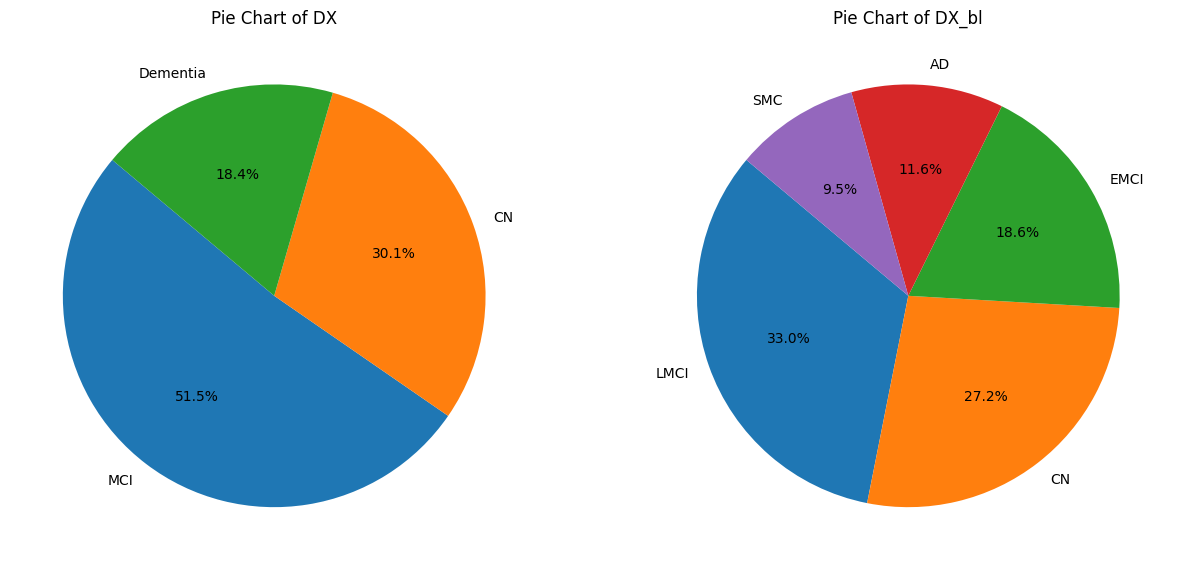

In [ ]:
# Count the occurrences of each unique value in the column
value_counts1 = data["DX"].value_counts()

plt.figure(figsize=(15, 10))

# Pie Chart
plt.subplot(1, 2, 1)
plt.pie(value_counts1, labels=value_counts1.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of {"DX"}')

value_counts2 = data["DX_bl"].value_counts()

# Pie Chart
plt.subplot(1, 2, 2)
plt.pie(value_counts2, labels=value_counts2.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of {"DX_bl"}')

plt.show()

## Years of Education

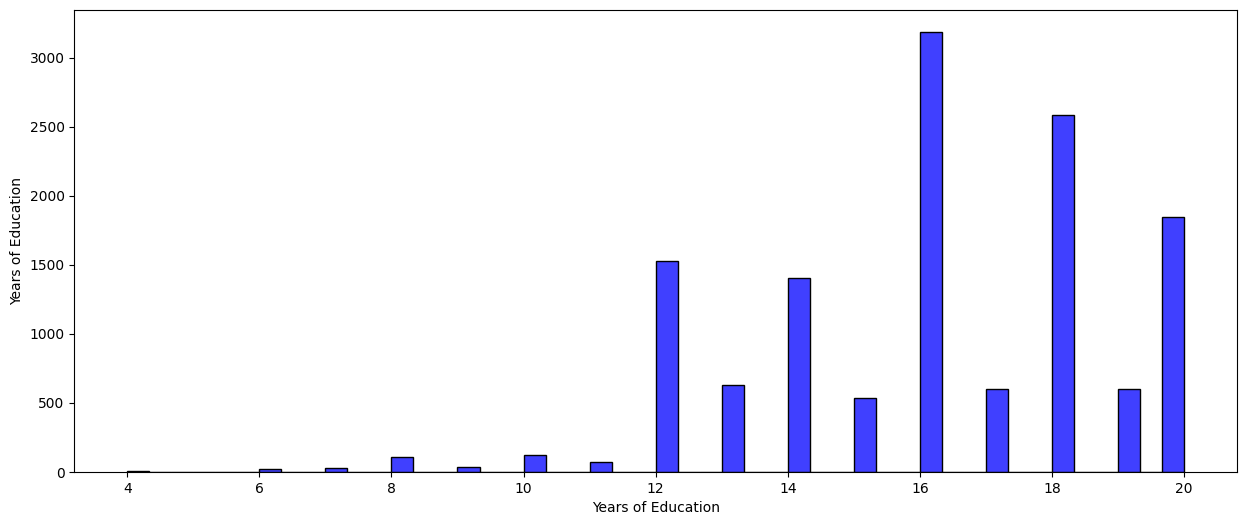

In [ ]:
# Plot the distribution using seaborn
plt.figure(figsize=(15, 6))
sns.histplot(data["PTEDUCAT"], color='blue')
plt.xlabel("Years of Education")
plt.ylabel('Years of Education')
plt.show()

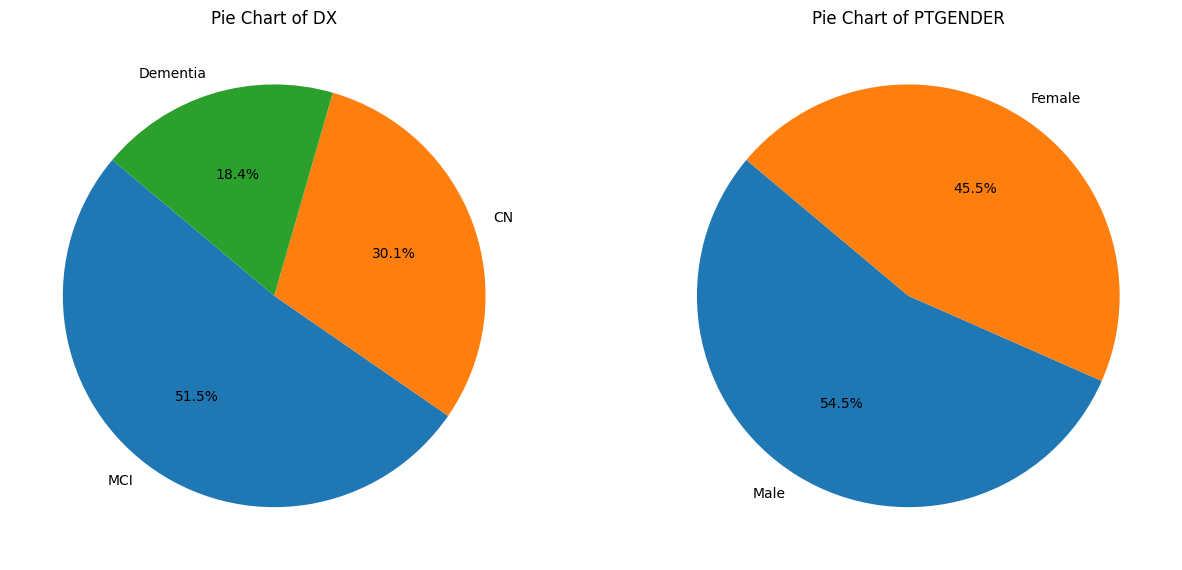

In [ ]:
# Count the occurrences of each unique value in the column
value_counts1 = data["DX"].value_counts()

plt.figure(figsize=(15, 10))

# Pie Chart
plt.subplot(1, 2, 1)
plt.pie(value_counts1, labels=value_counts1.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of {"DX"}')

value_counts2 = data["PTGENDER"].value_counts()

# Pie Chart
plt.subplot(1, 2, 2)
plt.pie(value_counts2, labels=value_counts2.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of {"PTGENDER"}')

plt.show()

### As seen above, the majority of participants are range between ages 65 and 85, with no participants aged below 50 or above 90. The participants are majority male (10% more males than females), and a significant proportion have some tertiary education.

In [ ]:

# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()


data['PTGENDER'] = label_encoder.fit_transform(data['PTGENDER'])
data['DX_bl'] = label_encoder.fit_transform(data['DX_bl'])
data['DX'] = label_encoder.fit_transform(data['DX'])


data


,AGE,PTGENDER,PTEDUCAT,DX_bl,APOE4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,DX
0,74.3,1,16,1,0.000000,28.000000,44.000000,4.00000,6.000000,54.545500,0
1,81.3,1,18,0,1.000000,20.000000,22.000000,1.00000,4.000000,100.000000,1
2,81.3,1,18,0,1.000000,24.000000,19.000000,2.00000,6.000000,100.000000,1
3,81.3,1,18,0,1.000000,17.000000,31.000000,2.00000,7.000000,100.000000,1
4,81.3,1,18,0,1.000000,19.000000,23.000000,1.00000,5.000000,100.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
16410,79.9,0,16,3,1.000000,28.000000,24.000000,2.00000,6.000000,100.000000,2
16412,71.4,0,18,3,0.528111,29.000000,58.000000,7.00000,0.000000,0.000000,2
16413,68.1,1,12,3,1.000000,25.000000,32.000000,5.00000,9.000000,90.000000,2
16415,65.0,0,18,4,0.000000,26.787132,35.649709,4.21973,4.164556,56.829056,2


### Imbalanced Dataset.
A classification data set with skewed class proportions is called imbalanced. Classes that make up a large proportion of the data set are called majority classes. Those that make up a smaller proportion are minority classes.
The dataset is imbalanced. MCI is majority class.and Dememsia is minority Class.

In [ ]:
data["DX_bl"].value_counts()

DX_bl
3    4384
1    3615
2    2475
0    1547
4    1268
Name: count, dtype: int64

## Correlation Analysis

Feature pairs with correlation > 0.75:
Features: RAVLT_forgetting and RAVLT_perc_forgetting, Correlation Measure: 0.72


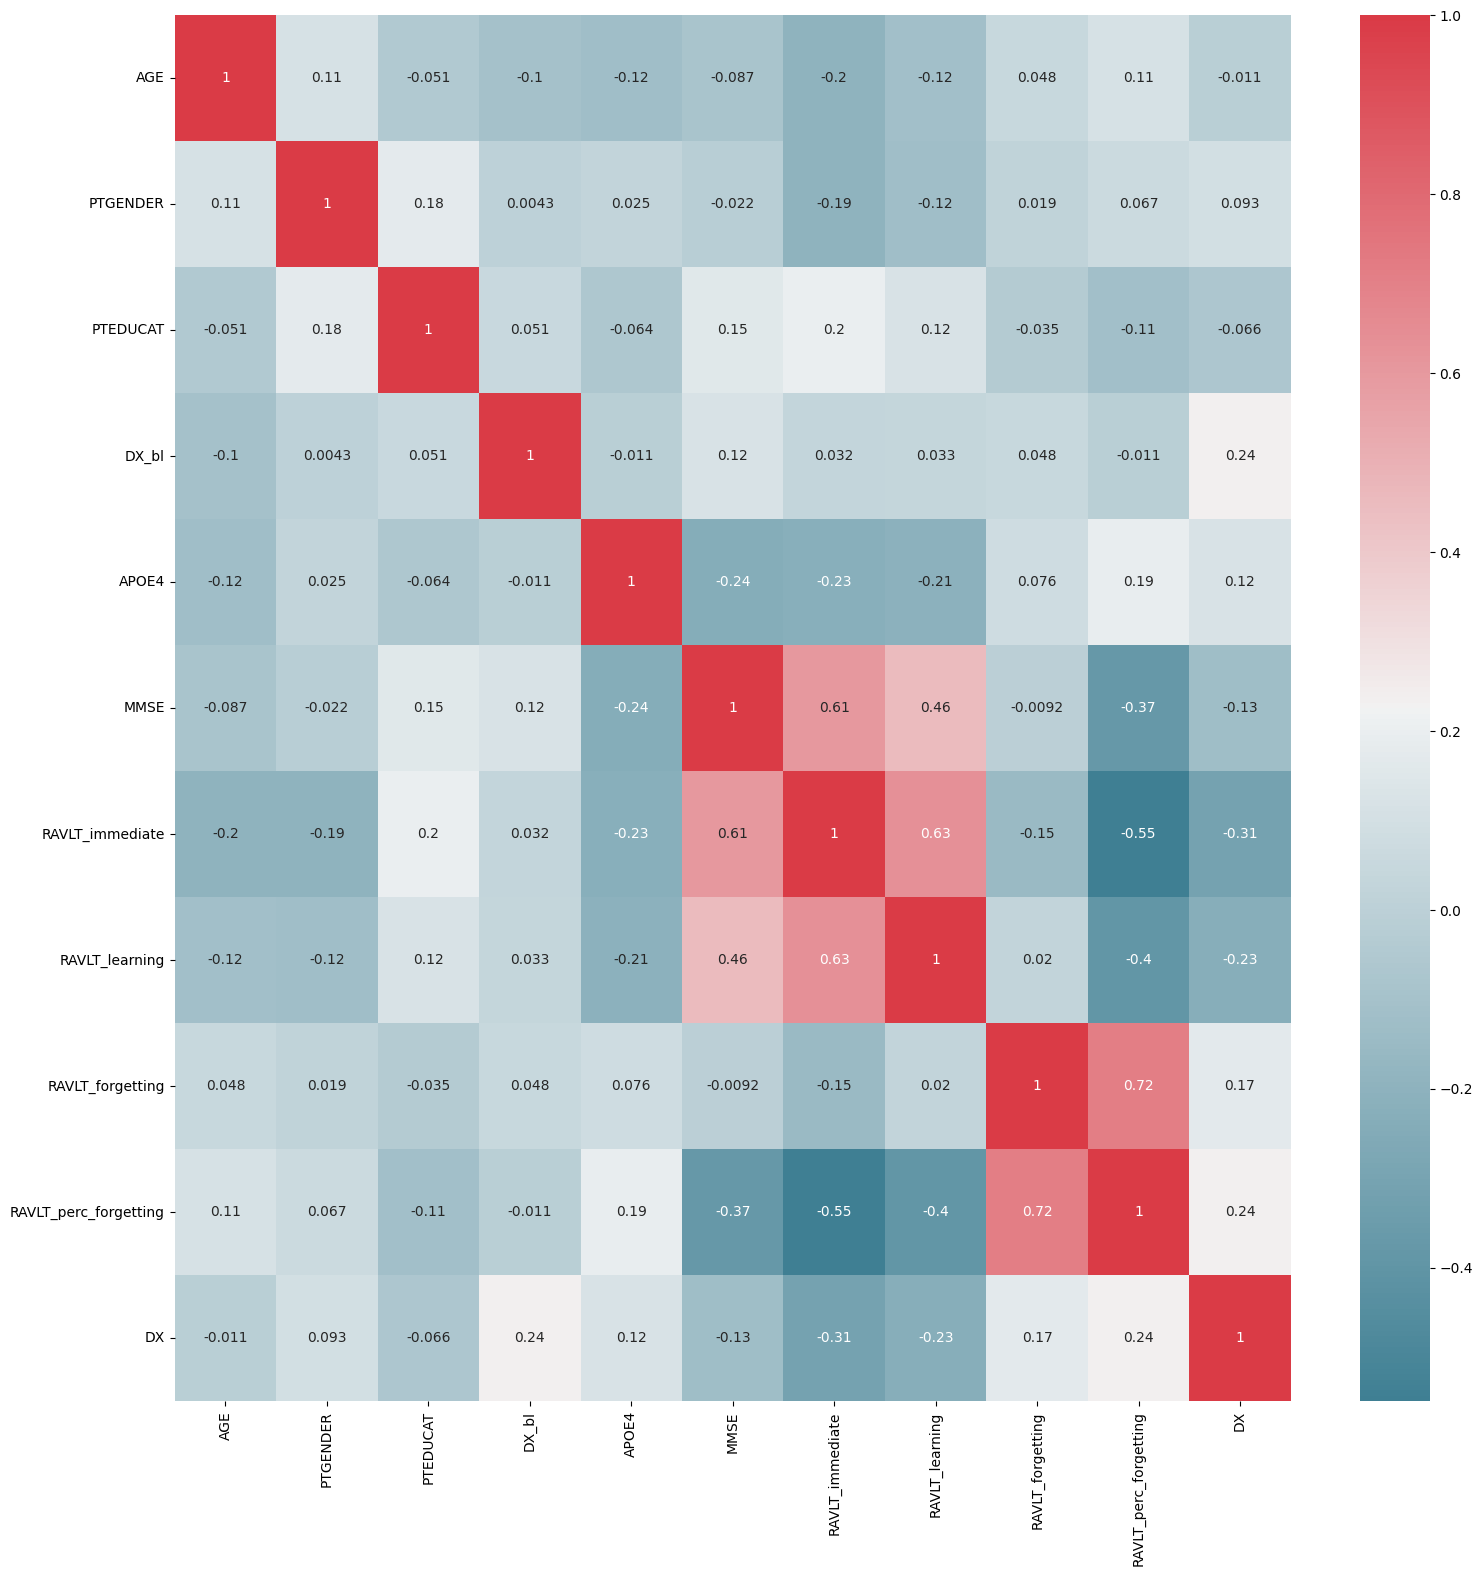

In [ ]:
# Visualize the correlation between features

correlation_matrix = data.corr()

_,ax=plt.subplots(figsize=(18,18))
colormap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(correlation_matrix,annot=True,cmap=colormap)

# Set the correlation threshold
threshold = 0.7

# Find features with correlation above the threshold
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            high_corr_pairs.append(feature_pair)

# Display features with correlation exceeding the threshold
print("Feature pairs with correlation > 0.75:")
for feature_pair in high_corr_pairs:
    print(f"Features: {feature_pair[0]} and {feature_pair[1]}, Correlation Measure: {correlation_matrix.loc[feature_pair[0], feature_pair[1]]:.2f}")

### The XGBoost model will input the features: "AGE", "PTGENDER", "PTEDUCAT", "APOE4", "MMSE" wihtout any idea on the premenilary diagnosis (Which is represented by "DX_bl") and output a dementia diagnosis.

## XGBoost (Baseline)

In [ ]:
# Separate the Targets from the Inputs (Inputs: "AGE", "PTGENDER", "PTEDUCAT", "APOE4", "MMSE", "RAVLT_immediate", "RAVLT_learning", "RAVLT_forgetting", "RAVLT_perc_forgetting", Outputs: "DX")

X1 = data[["AGE", "PTGENDER", "PTEDUCAT", "DX_bl", "APOE4",  "MMSE", "RAVLT_immediate", "RAVLT_learning", "RAVLT_forgetting", "RAVLT_perc_forgetting"]]
y1 = data["DX"]

X1.head(3)

,AGE,PTGENDER,PTEDUCAT,DX_bl,APOE4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting
0,74.3,1,16,1,0.0,28.0,44.0,4.0,6.0,54.5455
1,81.3,1,18,0,1.0,20.0,22.0,1.0,4.0,100.0000
2,81.3,1,18,0,1.0,24.0,19.0,2.0,6.0,100.0000


In [ ]:
# Convert categorical features to numbers so they can be digested by ML models : Apply one-hot encoding: This will create two columns for the gender feature ['Female', 'Male']

#X1 = pd.get_dummies(X1, columns=X1.select_dtypes(include=['object']).columns)
# Convert the AGE column to integers
X1['AGE'] = X1['AGE'].astype(int)


<ipython-input-18-08d5281bdbcf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1['AGE'] = X1['AGE'].astype(int)


In [ ]:
# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=2)

#label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

# Define hyperparameter grid for grid search
param_grid = [{
    'max_depth': [3, 5, 7, 10, 15, 17],
    'learning_rate': [0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.9, 1]
}]

print("The model for {} is Training ......")
# Create a base XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_xgb_classifier = xgb.XGBClassifier(**best_params)
final_xgb_classifier.fit(X_train, y_train)

# Save the best model
joblib.dump(final_xgb_classifier, 'best_xgb_model_ADNI1.joblib')

# Save the best_params
joblib.dump(best_params, 'best_parameters_ADNI1.joblib')

The model for {} is Training ......
Best Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


['best_parameters_ADNI1.joblib']

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_pred = final_xgb_classifier.predict(X_test)
#y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate AUC-ROC for each column
auc_roc_scores = []

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

y_scores = final_xgb_classifier.predict_proba(X_test)

# Display overall results
print("\nOverall Results:")
print("Accuracy: {:.2f} %".format(accuracy * 100))
print("Classification Report:\n", classification_rep)


Overall Results:
Accuracy: 88.64 %
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91       771
           1       0.87      0.79      0.83       495
           2       0.88      0.91      0.89      1392

    accuracy                           0.89      2658
   macro avg       0.89      0.87      0.88      2658
weighted avg       0.89      0.89      0.89      2658



<Figure size 1000x800 with 0 Axes>

AUC-ROC (0): 0.98
AUC-ROC (1): 0.97
AUC-ROC (2): 0.95
Average AUC-ROC: 0.97


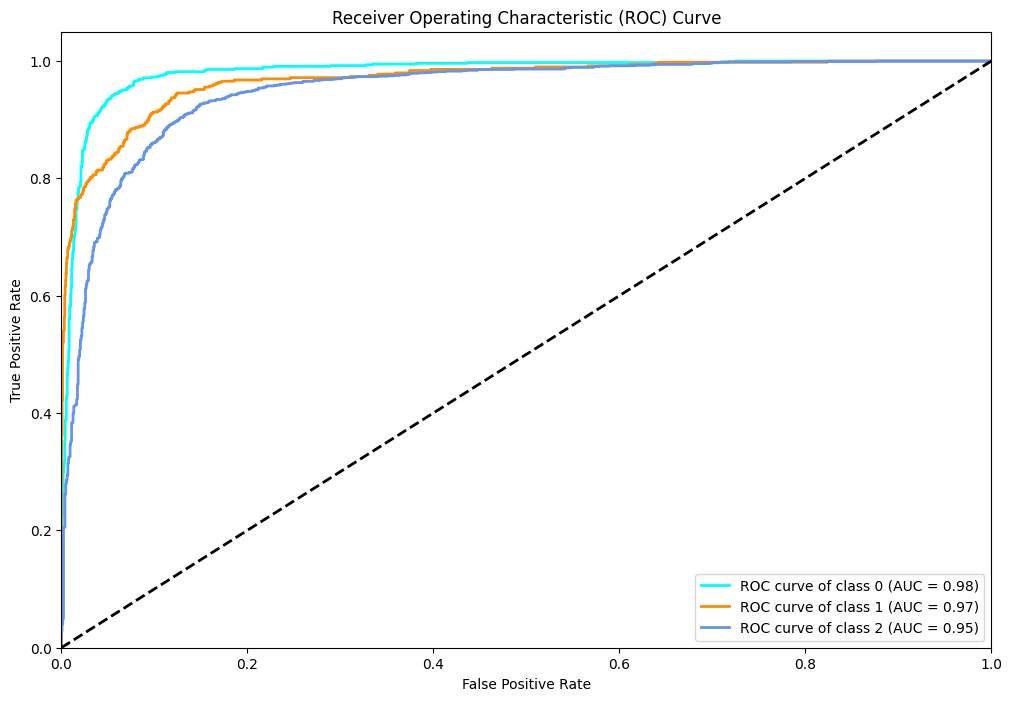

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Calculate AUC-ROC for each class
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

auc_roc_scores = []

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    auc_roc_scores.append(roc_auc[i])
    print(f"AUC-ROC ({i}): {roc_auc[i]:.2f}")

print("Average AUC-ROC: {:.2f}".format(np.mean(auc_roc_scores)))

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Create an instance of One-hot-encoder
enc = OneHotEncoder()
y_test_encoded=enc.fit_transform( pd.DataFrame(y_test)).toarray()
#    data[['Gen_new', 'Rem_new']]).toarray())


In [ ]:
def brier_multi(targets, probs):
  return np.mean(np.sum((probs - targets)**2, axis=1))

### Brier scores, calibration plots, AUC-ROC metrics

In [ ]:
from sklearn.metrics import brier_score_loss
# keep the predictions for class 1 only

probs = y_scores  #[:, 1]
# calculate bier score
loss = brier_multi(y_test_encoded, probs)

In [ ]:
loss

0.17382291620862317

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

cal_clf = CalibratedClassifierCV(final_xgb_classifier, method="sigmoid", cv="prefit")
cal_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=1, device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=7,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=50, n_jobs=None,
                                               num_parallel_tree=None,
                                               objective='multi:softprob', ...))

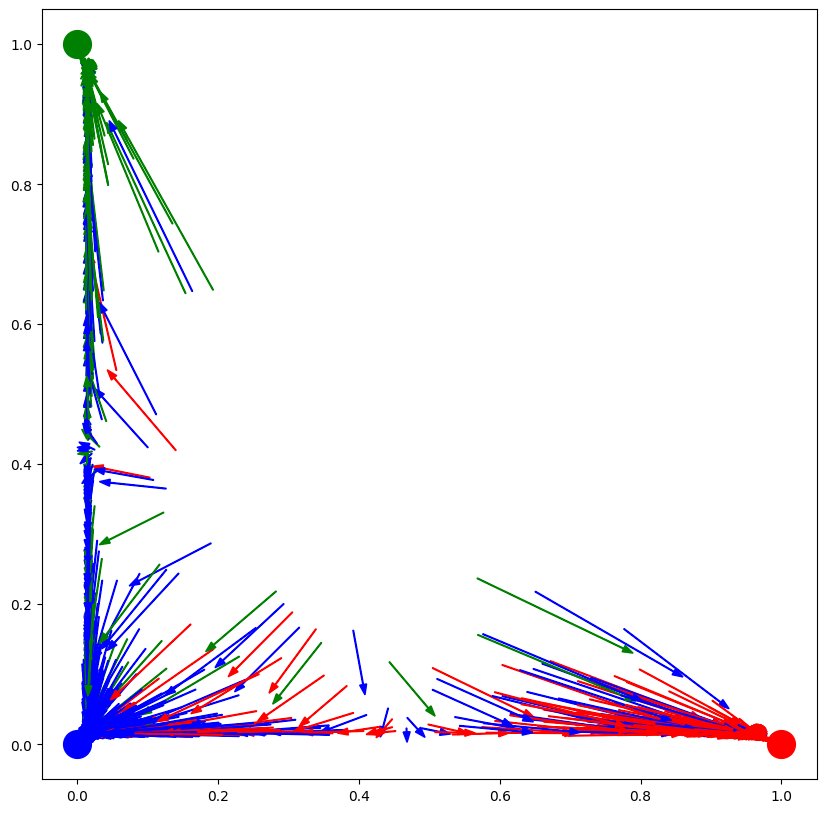

In [ ]:
plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots(figsize=(20, 10))
colors = ["r", "g", "b"]

clf_probs = final_xgb_classifier.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)
# Plot arrows

# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color=colors[y_test.iloc[i]],
        head_width=1e-2,
    )

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], "ro", ms=20, label="Class 1")
plt.plot([0.0], [1.0], "go", ms=20, label="Class 2")
plt.plot([0.0], [0.0], "bo", ms=20, label="Class 3")


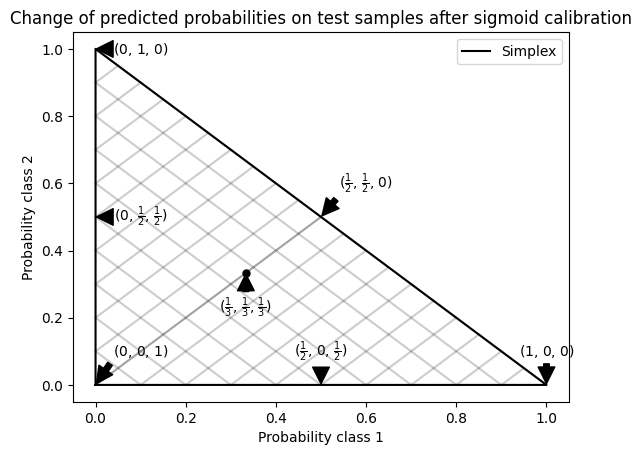

In [ ]:

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(
    r"($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)",
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.plot([1.0 / 3], [1.0 / 3], "ko", ms=5)
plt.annotate(
    r"($\frac{1}{2}$, $0$, $\frac{1}{2}$)",
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $\frac{1}{2}$, $\frac{1}{2}$)",
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($\frac{1}{2}$, $\frac{1}{2}$, $0$)",
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $0$, $1$)",
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($1$, $0$, $0$)",
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $1$, $0$)",
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Change of predicted probabilities on test samples after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

### Survival analysis with Cox Model implementation

In [ ]:
pip install lifelines

In [ ]:
pip install matplotlib

In [ ]:
from lifelines import KaplanMeierFitter

<Axes: xlabel='timeline'>

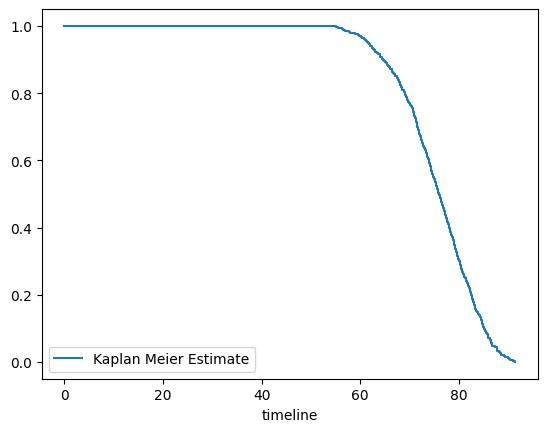

In [ ]:

T = data.AGE
E = data.DX

## create a kmf object
km = KaplanMeierFitter()

## Fit the data into the model
km.fit(T, E,label='Kaplan Meier Estimate')

## Create an estimate
km.plot(ci_show=False) ## ci_show is meant for Confidence interval, since our data set is too tiny, not showing it.

<Axes: xlabel='timeline'>

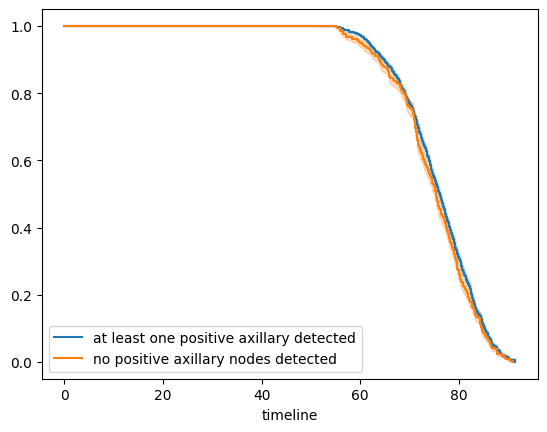

In [ ]:
## Instantiate the class to create an object
km_2 = KaplanMeierFitter()

## creating 2 cohorts : with at least one positive axillary detected, and one with no one detected
groups = data['DX_bl']
i1 = (groups >= 1)
i2 = (groups < 1)


## fit the model for 1st cohort
km_2.fit(T[i1], E[i1], label='at least one positive axillary detected')
a1 = km_2.plot()

## fit the model for 2nd cohort
km_2.fit(T[i2], E[i2], label='no positive axillary nodes detected')
km_2.plot(ax=a1)

In [ ]:
from lifelines import CoxPHFitter
# Create Model
cph = CoxPHFitter()

# Fit the data to train the model
cph.fit(data, 'AGE', event_col='DX')

# Have a look at the significance of the features
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 13289 total observations, 4006 right-censored observations>
             duration col = 'AGE'
                event col = 'DX'
      baseline estimation = breslow
   number of observations = 13289
number of events observed = 9283
   partial log-likelihood = -77866.90
         time fit was run = 2024-02-16 10:17:27 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
PTGENDER              -0.15      0.86      0.02           -0.20           -0.11                0.82                0.90
PTEDUCAT               0.00      1.00      0.00           -0.00            0.01                1.00                1.01
DX_bl                  0.15      1.16      0.01            0.13            0.17                1.14                1.18
APOE4                  0.39      1.47      0.02            0.35            0.42                1.42                1.52
MMSE                  -0.03      0.97      0.00           -0.03           -0.02                0.97                0.98
RAVLT_immediate       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
RAVLT_learning        -0.04      0.97      0.01           -0.05           -0.02                0.95                0.98
RAVLT_forgetting       0.04      1.04      0.01            0.02            0.06                1.02                1.06
RAVLT_perc_forgetting -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                       cmp to     z      p  -log2(p)
covariate                                           
PTGENDER                 0.00 -6.92 <0.005     37.66
PTEDUCAT                 0.00  0.63   0.53      0.92
DX_bl                    0.00 17.49 <0.005    225.02
APOE4                    0.00 23.49 <0.005    402.94
MMSE                     0.00 -7.47 <0.005     43.52
RAVLT_immediate          0.00 -1.11   0.27      1.91
RAVLT_learning           0.00 -5.93 <0.005     28.27
RAVLT_forgetting         0.00  5.04 <0.005     21.01
RAVLT_perc_forgetting    0.00 -0.82   0.41      1.27
---
Concordance = 0.60
Partial AIC = 155751.80
log-likelihood ratio test = 1278.20 on 9 df
-log2(p) of ll-ratio test = 892.94

<Axes: xlabel='log(HR) (95% CI)'>

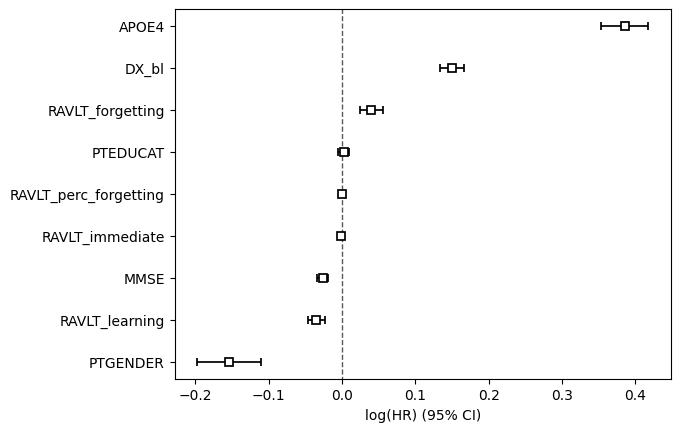

In [ ]:
cph.plot()

In [ ]:
## I want to see the Survival curve at the patient level.
## Random patients
patients = [4,125,211]

rows_selected = data.iloc[patients, :]
rows_selected

,AGE,PTGENDER,PTEDUCAT,DX_bl,APOE4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,DX
4,81.3,1,18,0,1.0,19.0,23.000000,1.00000,5.000000,100.000000,1
125,70.9,0,13,1,0.0,30.0,42.000000,9.00000,2.000000,16.666700,0
211,65.6,1,8,0,2.0,12.0,35.649709,4.21973,4.164556,56.829056,1


<Axes: >

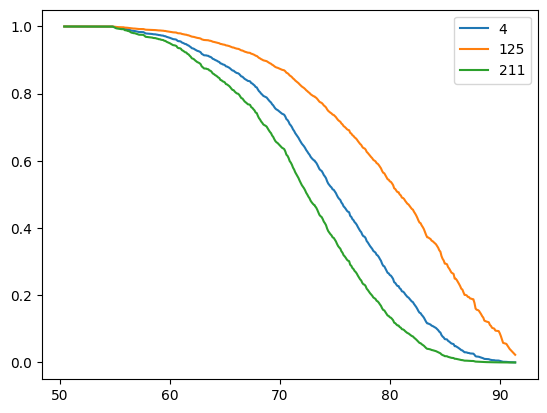

In [ ]:
cph.predict_survival_function(rows_selected).plot()

**Kaplan-Meier Survival Estimates:**

The Kaplan-Meier survival curve is a non-parametric statistic used to estimate the survival function from lifetime data. In your case, it seems to be used to estimate the survival function for Alzheimer's disease progression based on age.
The first Kaplan-Meier plot suggests that there is a survival estimate over time (age) for the entire dataset.

The second Kaplan-Meier plot differentiates between two cohorts: those with at least one positive axillary node detected and those with none. This differentiation is likely to be a part of subgroup analysis within the data.

**Cox Proportional Hazards Model:**

The Cox Proportional Hazards Model is a semiparametric model used for survival analysis to analyze the effect of various variables on the survival time.

The provided summary table indicates that certain factors, such as the presence of the APOE4 allele, initial diagnosis (DX_bl), and gender, have statistically significant effects on the survival times. Specifically, APOE4 has a hazard ratio (exp(coef)) of 1.47, indicating a 47% increase in the hazard for every one-unit increase in APOE4.

The concordance index of 0.60 suggests moderate predictive power for the Cox model.

**Patient-Level Survival Curves:**

The survival curves for selected patients (with IDs 4, 125, 211) show the predicted survival function for these individuals. These curves can provide personalized survival predictions based on the Cox model.

**Analysis of Plots:**

Kaplan-Meier Plot for Overall Data: The curve starts at 1 and drops over the age timeline, which is expected as the probability of surviving without AD diagnosis decreases with age.

Kaplan-Meier Plot for Two Cohorts: Both cohorts start with a survival probability of 1 and follow a similar trajectory over time. This could suggest that the presence of positive axillary nodes is not differentiating the survival probabilities significantly in this case.

CoxPH Model Feature Importance Plot: The forest plot shows the log(Hazard Ratios) and their 95% confidence intervals for each feature in the model. APOE4 and DX_bl are notably significant with higher hazard ratios, indicating a stronger impact on survival.

Patient-Level Survival Curves: These curves provide individualized survival probabilities based on the features of each patient. The curves show variability between patients, reflecting the personalized risk based on their data.

### Demographic parity__: the prediction should be independent from the sensitive features (for instance independent from gender). It states that all categories from the protected feature should receive the positive outcome at the same rate

In [ ]:
!pip install fairlearn

## FairLearn
* _Which groups are most likely to be disproportionately negatively affected?
We will see the results of the classification as per each gender group

In [ ]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)


In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

In [ ]:
# pandified confusion matrix with clarifying column annotations
def confusion_matrix_pd(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred, normalize='all')
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2"}).stack()

# construct metric frame
mf = MetricFrame(metrics=confusion_matrix_pd,
                  y_true=y_test, y_pred=y_pred,
                  sensitive_features=X_test['PTGENDER'])

# mf.by_group needs to be transformed to work properly
comput_mf=pd.DataFrame(mf.by_group.to_dict()).T.rename_axis(index='gender')
comput_mf

true=0                        true=1                        true=2  \
          pred=0    pred=1    pred=2    pred=0    pred=1    pred=2    pred=0   
gender                                                                         
0       0.312292  0.000000  0.023256  0.002492  0.142027  0.036545  0.024917   
1       0.224897  0.000688  0.026823  0.000688  0.151307  0.038514  0.029574   

                            
          pred=1    pred=2  
gender                      
0       0.023256  0.435216  
1       0.019945  0.507565

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

gm = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=X_test['PTGENDER'])
print(gm.overall)
print(gm.by_group)

0.8863807373965388
PTGENDER
0    0.889535
1    0.883769
Name: accuracy_score, dtype: float64


In [ ]:
def precision_score_pd(y_true, y_pred):
    matrix = precision_score(y_true, y_pred,average=None)
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2"}).stack()

gm = MetricFrame(metrics=precision_score_pd, y_true=y_test, y_pred=y_pred, sensitive_features=X_test['PTGENDER'])
print(gm.overall)
print(gm.by_group)

true=0  pred=0    0.901282
true=1  pred=0    0.870824
true=2  pred=0    0.883135
dtype: float64
PTGENDER
0    true=0  pred=0    0.919315
true=1  pred=0    0...
1    true=0  pred=0    0.881402
true=1  pred=0    0...
Name: precision_score_pd, dtype: object


In [ ]:
def recall_score_pd(y_true, y_pred):
    matrix = recall_score(y_true, y_pred,average=None)
    return pd.DataFrame(matrix).rename(
               index={0: "true=0", 1: "true=1", 2: "true=2"},
               columns={0: "pred=0", 1: "pred=1", 2: "pred=2"}).stack()

gm = MetricFrame(metrics=recall_score_pd, y_true=y_test, y_pred=y_pred, sensitive_features=X_test['PTGENDER'])
print(gm.overall)
print(gm.by_group)

true=0  pred=0    0.911803
true=1  pred=0    0.789899
true=2  pred=0    0.906609
dtype: float64
PTGENDER
0    true=0  pred=0    0.930693
true=1  pred=0    0...
1    true=0  pred=0    0.891008
true=1  pred=0    0...
Name: recall_score_pd, dtype: object


Model Performance Metrics

Accuracy (88.64%): The model achieves a high accuracy rate, indicating that it correctly predicts the diagnosis (DX) for a significant majority of cases in the test data. This suggests that the model is generally effective in distinguishing between the different diagnostic categories defined in your target variable DX.

Precision and Recall:
 The precision and recall metrics, especially when broken down by the true labels (0, 1, 2), provide a nuanced view of model performance. High precision for class 0 and class 2 suggests that when the model predicts these classes, it is highly likely to be correct. The recall values indicate that the model is also quite good at capturing the true instances of these classes.

Fairness Analysis (Metrics by Group)

The Fairlearn MetricFrame analysis reveals differences in model performance across groups defined by the sensitive feature PTGENDER. This is critical for understanding how the model's predictions may vary based on gender, which is essential for assessing model fairness.

Disaggregated Metrics:
 The accuracy scores across genders (0 and 1) are relatively close, with gender 1 having slightly higher accuracy. This suggests that the model's ability to correctly predict outcomes does not significantly differ between these groups, which is a positive sign from a fairness perspective.

Precision and Recall by Gender:
 The custom precision and recall metrics, as structured, suggest differences in how well the model identifies positive cases (precision) and how often its positive predictions are correct (recall) across genders. These differences highlight areas where the model's performance might be improved to ensure equitable outcomes across gender groups.

AUC-ROC Analysis

The AUC-ROC scores are exceptionally high (around 0.95 to 0.98), indicating that the model has excellent discriminative ability to distinguish between the classes for the problem at hand. High AUC-ROC scores across all classes demonstrate the model's effectiveness across varied diagnostic outcomes.

Interpretation and Recommendations

Performance: The XGBoost model exhibits strong predictive performance, making it a reliable tool for the task. Its high accuracy and AUC-ROC scores across classes confirm its effectiveness.

Fairness Concerns:
 While the model shows relatively balanced accuracy across genders, the presence of any disparities in precision and recall suggests room for improvement. It's crucial to investigate the causes of these disparities—whether they stem from imbalances in the training data, inherent biases in the model's learning process, or other factors.

### Improving Modeling by handling imbalance
Oversampling Minority Class
Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don't have a ton of data to work with. A con to consider when undersampling is that it can cause overfitting and poor generalization to your test set.

Our approach to addressing class imbalance using SMOTE (Synthetic Minority Over-sampling Technique) and retraining the XGBoost classifier with the balanced dataset demonstrates a strategic method to improve machine learning model performance, particularly in scenarios where class distribution is skewed. Here's a summary and analysis of the steps you've taken:

SMOTE for Class Balancing

we've successfully applied SMOTE to balance the classes in your dataset. This technique generates synthetic samples for minority classes, aiming to create a balanced class distribution. Your results show an equal distribution among the three classes, which is ideal for training a model that performs well across all categories without bias towards the majority class.

Model Retraining

After balancing the classes, we've split the dataset into training and test sets again and retrained the XGBoost classifier using a grid search to find the best hyperparameters. The model retraining with the balanced dataset aims to improve the classifier's ability to generalize across all classes by learning from a more representative sample distribution.

Model Evaluation

The evaluation of the retrained model shows a significant improvement in accuracy (93.03%), which is a considerable increase compared to the initial training on the imbalanced dataset. This highlights the effectiveness of addressing class imbalance in improving model performance.

The classification report provides detailed insights into the model's precision, recall, and F1-score for each class, showing strong performance across all metrics. This indicates that the model is not only accurate overall but also maintains a balanced performance across different classes, reducing the risk of favoring one class over others.
AUC-R

Class=0, n=6843 (33.333%)
Class=1, n=6843 (33.333%)
Class=2, n=6843 (33.333%)


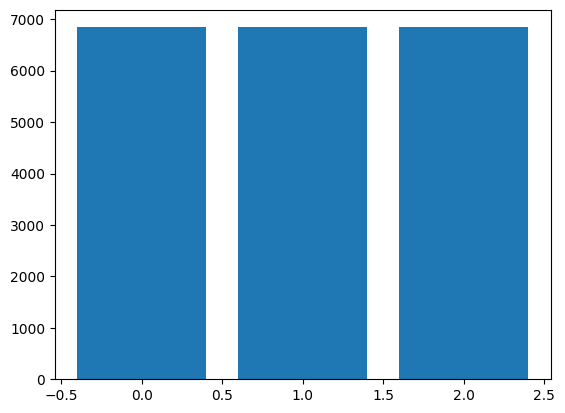

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X1, y1)
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()



In [ ]:
# Assuming X and y are your features and target variable
X_train_New, X_test_New, y_train_New, y_test_New = train_test_split(X, y, test_size=0.2, random_state=2)

label_encoder = LabelEncoder()
y_train_New_encoded = label_encoder.fit_transform(y_train_New)
y_test_New_encoded = label_encoder.transform(y_test_New)

# Define hyperparameter grid for grid search
param_grid = [{
    'max_depth': [3, 5, 7, 10, 15, 17],
    'learning_rate': [0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.9, 1]
}]

print("The model for {} is Training ......")
# Create a base XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_New, y_train_New_encoded)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_xgb_classifier = xgb.XGBClassifier(**best_params)
final_xgb_classifier.fit(X_train_New, y_train_New_encoded)

# Save the best model
joblib.dump(final_xgb_classifier, 'best_xgb_model_ADNI1_New.joblib')

# Save the best_params
joblib.dump(best_params, 'best_parameters_ADNI1_New.joblib')

The model for {} is Training ......
Best Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}


['best_parameters_ADNI1_New.joblib']

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_pred_New_encoded = final_xgb_classifier.predict(X_test_New)
y_pred_New = label_encoder.inverse_transform(y_pred_New_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test_New, y_pred_New)
classification_rep_New = classification_report(y_test_New, y_pred_New)

# Calculate AUC-ROC for each column
auc_roc_scores = []

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

y_scores_New = final_xgb_classifier.predict_proba(X_test_New)

# Display overall results
print("\nOverall Results:")
print("Accuracy: {:.2f} %".format(accuracy * 100))
print("Classification Report:\n", classification_rep_New)


Overall Results:
Accuracy: 92.23 %
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      1350
           1       0.95      0.94      0.94      1392
           2       0.89      0.89      0.89      1364

    accuracy                           0.92      4106
   macro avg       0.92      0.92      0.92      4106
weighted avg       0.92      0.92      0.92      4106



<Figure size 1000x800 with 0 Axes>

In [ ]:
y_test_new_encoded=enc.fit_transform( pd.DataFrame(y_test_New)).toarray()
#    data[['Gen_new', 'Rem_new']]).toarray())


In [ ]:
probs = y_scores_New  #[:, 1]
# calculate bier score
loss = brier_multi(y_test_new_encoded, probs)

In [ ]:
loss

0.11755031570984512

In [ ]:
cal_clf = CalibratedClassifierCV(final_xgb_classifier, method="sigmoid", cv="prefit")
cal_clf.fit(X_train_New, y_train_New)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=1, device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=10, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=200, n_jobs=None,
                                               num_parallel_tree=None,
                                               objective='multi:softprob', ...))

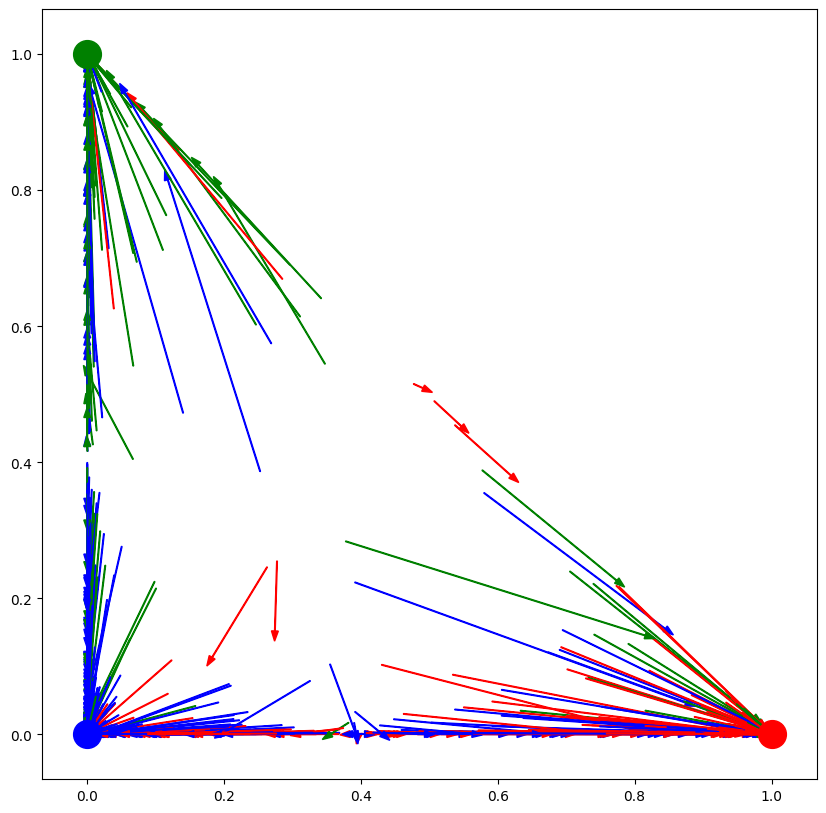

In [ ]:
plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots(figsize=(20, 10))
colors = ["r", "g", "b"]

clf_probs = final_xgb_classifier.predict_proba(X_test_New)
cal_clf_probs = cal_clf.predict_proba(X_test_New)
# Plot arrows

# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color=colors[y_test_New.iloc[i]],
        head_width=1e-2,
    )

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], "ro", ms=20, label="Class 1")
plt.plot([0.0], [1.0], "go", ms=20, label="Class 2")
plt.plot([0.0], [0.0], "bo", ms=20, label="Class 3")


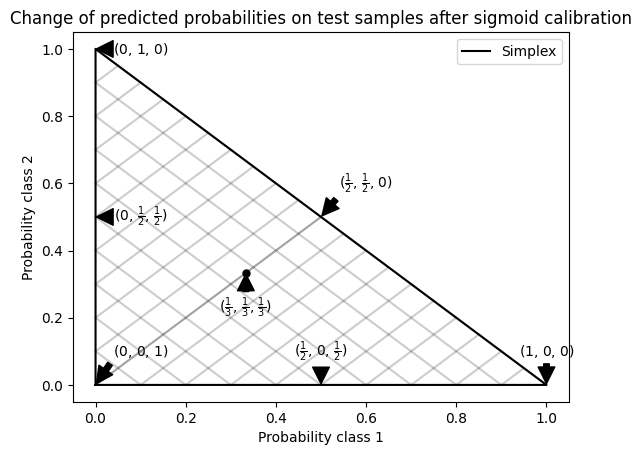

In [ ]:

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(
    r"($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)",
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.plot([1.0 / 3], [1.0 / 3], "ko", ms=5)
plt.annotate(
    r"($\frac{1}{2}$, $0$, $\frac{1}{2}$)",
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $\frac{1}{2}$, $\frac{1}{2}$)",
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($\frac{1}{2}$, $\frac{1}{2}$, $0$)",
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $0$, $1$)",
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($1$, $0$, $0$)",
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $1$, $0$)",
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Change of predicted probabilities on test samples after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

## Generating SHAP explanations and analyzing feature importance

In [ ]:
!pip install shap

In [ ]:
import shap


In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(final_xgb_classifier)
shap_values = explainer.shap_values(X_train)

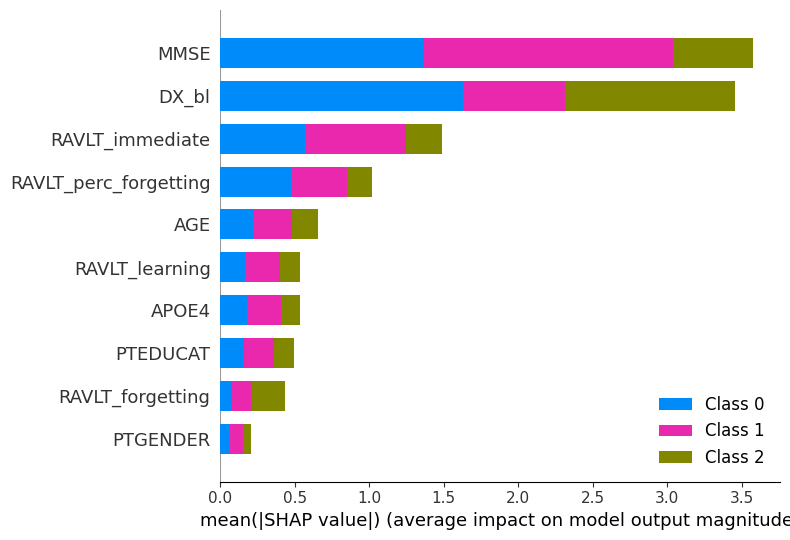

In [ ]:
#shap.plots.beeswarm(shap_values, max_display=20)
shap.summary_plot(shap_values, X_train )


The SHAP summary plot shows the average impact of each feature on the model output for a multi-class classification problem. Each row represents a feature, and each color represents a class. The length of the bar represents the mean absolute SHAP value for that feature, which is a measure of the impact of that feature on the model's prediction. A longer bar means the feature is more important.

In  plot, the MMSE feature has the most significant impact on the model's output across all classes. DX_bl and RAVLT_immediate also appear to be important, especially for class 0 and class 2. The plot shows that features like PTGENDER and RAVLT_forgetting have less impact on the model's predictions across the classes.

This plot is useful for understanding which features the model is using to make predictions and how each feature influences the prediction for each class.

In [ ]:
#shap.force_plot(explainer.expected_value[0], shap_values[0])

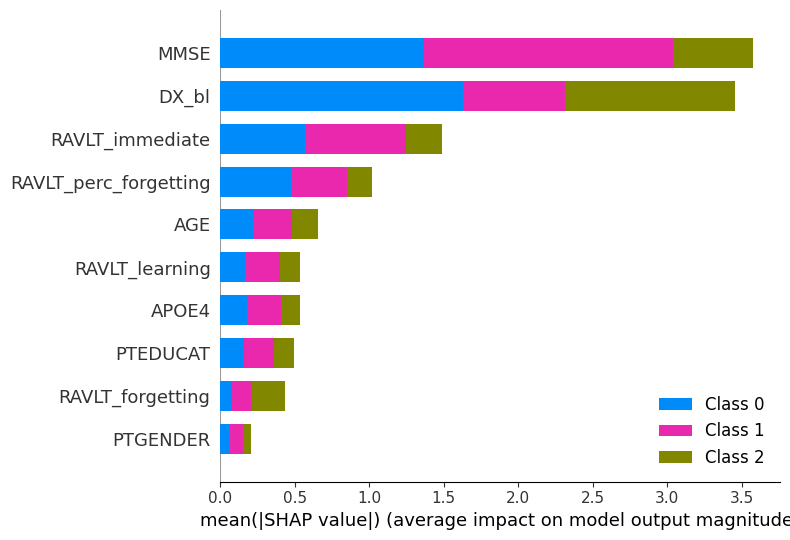

In [ ]:
shap.summary_plot(shap_values, X_test)

## Comparing to baseline models, such as logistic regression

In [ ]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(solver='lbfgs', max_iter=3000 )
logreg.fit(X_train, y_train_encoded)

LogisticRegression(max_iter=3000)

In [ ]:
y_train_encoded

array([0, 0, 0, ..., 2, 2, 0])

In [ ]:

y_pred_encoded = logreg.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate AUC-ROC for each column
auc_roc_scores = []

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

y_scores = logreg.predict_proba(X_test)

# Display overall results
print("\nOverall Results:")
print("Accuracy: {:.2f} %".format(accuracy * 100))
print("Classification Report:\n", classification_rep)


Overall Results:
Accuracy: 77.46 %
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71       771
           1       0.86      0.76      0.81       495
           2       0.77      0.82      0.79      1392

    accuracy                           0.77      2658
   macro avg       0.79      0.76      0.77      2658
weighted avg       0.78      0.77      0.77      2658



<Figure size 1000x800 with 0 Axes>

AUC-ROC (0): 0.89
AUC-ROC (1): 0.96
AUC-ROC (2): 0.84
Average AUC-ROC: 0.90


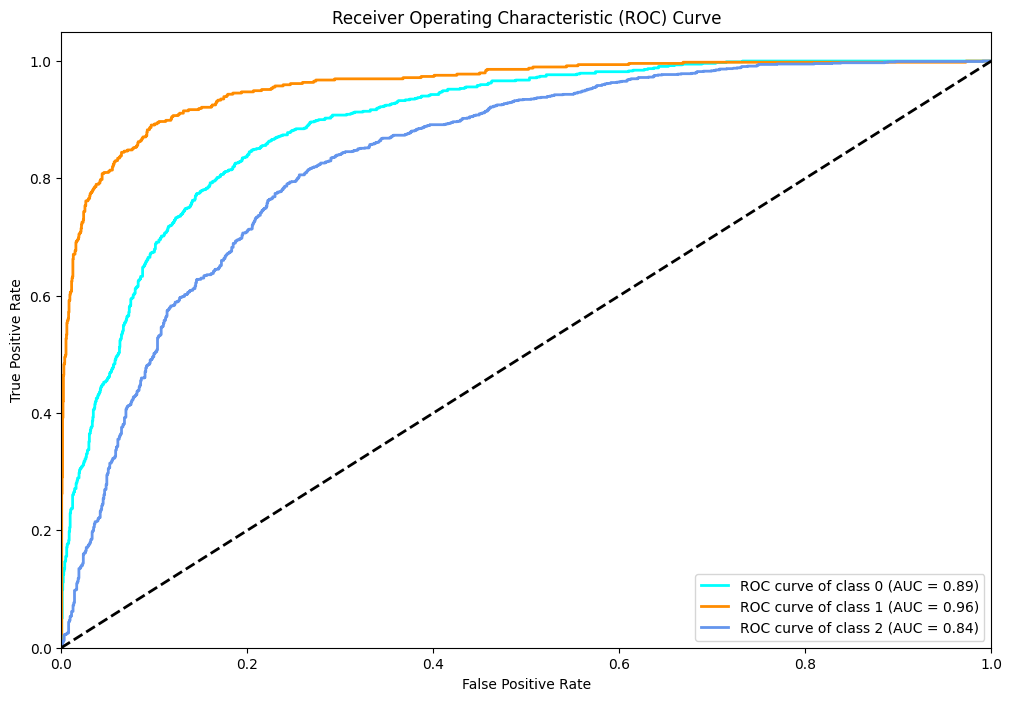

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Calculate AUC-ROC for each class
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()

auc_roc_scores = []

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    auc_roc_scores.append(roc_auc[i])
    print(f"AUC-ROC ({i}): {roc_auc[i]:.2f}")

print("Average AUC-ROC: {:.2f}".format(np.mean(auc_roc_scores)))

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**Logistic Regression Model Performance:**
Accuracy: The logistic regression model achieved an accuracy of 77.46%, which is lower than the 88.64% achieved by the XGBoost model.

**Precision, Recall, and F1-Score:** The classification report indicates that the logistic regression model has lower precision, recall, and F1-scores for each class compared to the XGBoost model.

**AUC-ROC Scores:** The average AUC-ROC score for the logistic regression model is 0.90, which is slightly lower than the 0.97 average AUC-ROC score for the XGBoost model. However, the scores for the logistic regression model are still high, suggesting good discriminative ability between the classes.

**Brier Score:**
The Brier score for the logistic regression model is 0.3316, which is higher than the Brier score of the XGBoost model (0.1738). Since a lower Brier score indicates better performance, the logistic regression model is less accurate in terms of probability estimates compared to the XGBoost model.

**Key Differences:**

**Model Complexity:** Logistic regression is generally a less complex model compared to gradient boosting models like XGBoost. It may not capture complex patterns in the data as effectively as XGBoost, which could explain the difference in performance.

**Interpretability:** Logistic regression models are typically more interpretable than XGBoost models since they provide coefficients that directly relate to the log odds of the outcomes.

**Training Time:** Logistic regression often requires less computational time to train compared to XGBoost, especially on large datasets, due to its simpler nature.

In [ ]:
y_test_encoded=enc.fit_transform( pd.DataFrame(y_test)).toarray()


In [ ]:
probs = y_scores  #[:, 1]
# calculate bier score
loss = brier_multi(y_test_encoded, probs)

In [ ]:
loss

0.33158358634903945

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

cal_clf = CalibratedClassifierCV(logreg, method="sigmoid", cv="prefit")
cal_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit', estimator=LogisticRegression(max_iter=3000))

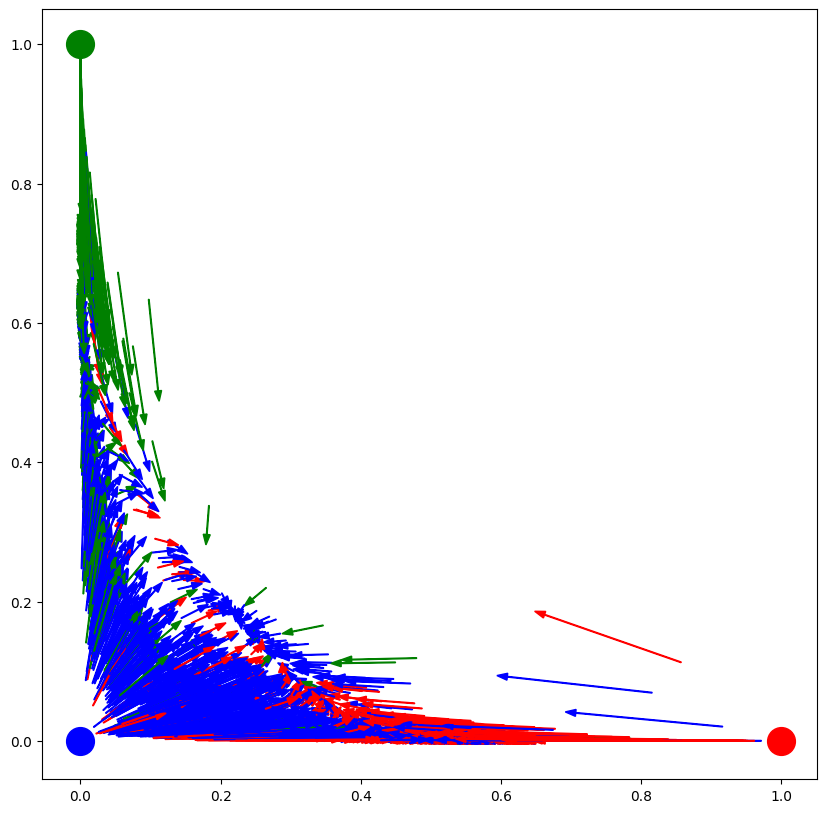

In [ ]:
plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots(figsize=(20, 10))
colors = ["r", "g", "b"]

clf_probs = logreg.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)
# Plot arrows

# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color=colors[y_test.iloc[i]],
        head_width=1e-2,
    )

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], "ro", ms=20, label="Class 1")
plt.plot([0.0], [1.0], "go", ms=20, label="Class 2")
plt.plot([0.0], [0.0], "bo", ms=20, label="Class 3")


# Analysis of the Calibration Plot:

**Arrows:** The arrows represent the changes in predicted probabilities after calibration. The base of an arrow is the predicted probability from the logistic regression model, and the head is the predicted probability after calibration.

**Colors:** The colors red (r), green (g), and blue (b) likely represent the three classes in the dataset. The dataset seems to be a multiclass classification problem since there are three colors used.

**Large Dots:** The large dots at the vertices of the triangle (0,0), (0,1), and (1,0) represent the perfect predictions for each class. A red dot at (1,0) means perfect prediction for Class 1, a green dot at (0,1) for Class 2, and a blue dot at (0,0) for Class 3.

**Density of Arrows:** The plot shows a high density of arrows pointing towards the vertices, indicating that the calibrated model's probabilities are moving closer to the ideal prediction points.

**Interpretation**:

The plot suggests that the calibration has adjusted the predicted probabilities to be more accurate. The arrows generally point towards the corners of the plot, which implies that the calibrated classifier is correcting the probabilities towards the expected perfect predictions.

A heavy concentration of arrows near the (0,0) point suggests that many instances are being predicted with high certainty to be of Class 3.
The widespread distribution of arrows along the base suggests varying degrees of certainty in the predictions, with the calibrated model generally increasing confidence in the predicted class.

The length and direction of the arrows indicate the extent and nature of the calibration adjustment. Arrows that point directly towards a corner show a major adjustment towards a specific class, while arrows that are more horizontal or vertical suggest adjustments between two classes.

**Key Takeaways:**

Calibration appears to have had a significant impact on the predicted probabilities, with a general trend of moving towards more certain predictions.
The model's confidence in its predictions has likely increased post-calibration, which could be beneficial if the original model was under-confident.

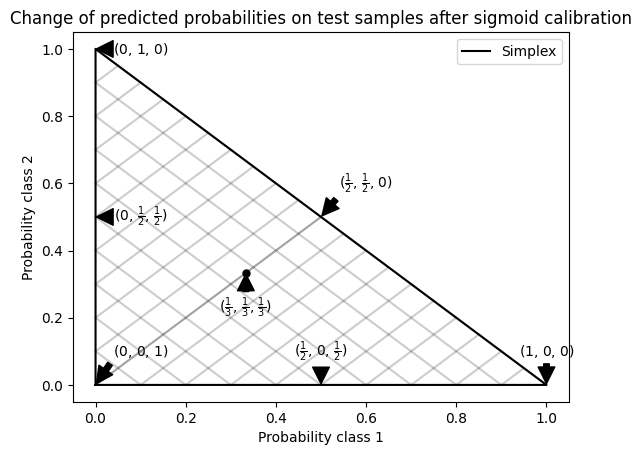

In [ ]:

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(
    r"($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)",
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.plot([1.0 / 3], [1.0 / 3], "ko", ms=5)
plt.annotate(
    r"($\frac{1}{2}$, $0$, $\frac{1}{2}$)",
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $\frac{1}{2}$, $\frac{1}{2}$)",
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($\frac{1}{2}$, $\frac{1}{2}$, $0$)",
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $0$, $1$)",
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($1$, $0$, $0$)",
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $1$, $0$)",
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Change of predicted probabilities on test samples after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

# Interpretation of the Simplex Plot:

Edges of the Triangle: Each vertex of the triangle corresponds to a 100% probability for one of the three classes. The edges represent scenarios where the model is certain about two classes, but the probability of the third is zero.

Interior Points: Points inside the triangle represent the predicted probabilities where there is some uncertainty, and the model assigns some probability to all three classes.

Annotations and Arrows: The annotations on the plot, along with the arrows, show specific probability points (e.g., 1/3,1/3,1/3) and the direction of change after calibration.

Grid Lines: The grid lines help in determining the ratio of the probabilities for the three classes. Each line represents a constant ratio between two of the classes.

**Key Takeaways:**

Probability Distribution: Most of the probability mass is located at the corners and edges of the triangle, indicating that the model is often quite certain about its predictions.

Change After Calibration: The arrows signify how the probabilities for a particular outcome change after calibration. For example, a point starting at
(1/3,1/3,1/3)  and moving closer to (0,1,0) suggests that calibration increased the model's confidence in Class 2 for that particular sample.

Model Confidence: If most arrows are pointing towards the corners or edges, it suggests that the calibration is making the model more confident in its predictions by shifting probabilities away from the uniform distribution in the center.

The logistic regression model's accuracy (77.43%) is significantly lower than the XGBoost model's accuracy (93.03%), as reported previously. This highlights the XGBoost model's superior ability to capture complex patterns in the data.


**XGBoost Model:** It achieved an accuracy of 88.64%, with high precision and recall across all classes. The model's AUC-ROC scores were also notably high (around 0.95 to 0.98), indicating excellent discrimination between classes.

**Logistic Regression Model:** This baseline model achieved a lower accuracy of 77.46%. While it showed high precision for class 1, its overall ability to identify true instances of each class (recall) was lower compared to the XGBoost model.

The logistic regression model you've trained and evaluated has an accuracy of 77.46%. The classification report shows precision, recall, and f1-score for each class (0, 1, 2). From the report, we can see:

Class 0 has a precision of 0.73, suggesting that when the model predicts class 0, it is correct 73% of the time. The recall of 0.70 indicates that it correctly identifies 70% of actual class 0 instances.

Class 1 shows higher precision at 0.86, meaning the model's predictions for class 1 are usually correct, but the recall is 0.76, so it misses some actual class 1 instances.
Class 2 has a precision of 0.77 and the highest recall at 0.82, indicating that while its predictions are slightly less precise than class 1, it is better at identifying most of the actual class 2 instances.

!pip install --upgrade matplotlib pandas fairlearn


In [ ]:
!pip install --upgrade matplotlib pandas fairlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


Metric by Group:
          accuracy
PTGENDER          
0         0.763289
1         0.784044


array([[<Axes: title={'center': 'accuracy'}, xlabel='PTGENDER'>,
        <Axes: xlabel='PTGENDER'>],
       [<Axes: xlabel='PTGENDER'>, <Axes: xlabel='PTGENDER'>],
       [<Axes: xlabel='PTGENDER'>, <Axes: xlabel='PTGENDER'>]],
      dtype=object)

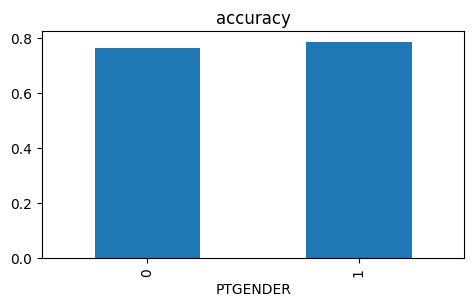

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
import matplotlib
# Define metrics that are applicable for multi-class
metrics = {
    'accuracy': accuracy_score,
    # Add any other multi-class supported metrics here
}

metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=X_test['PTGENDER'])

print("Metric by Group:")
print(metric_frame.by_group)

# If you want to visualize the disparities in metrics
metric_frame.by_group.plot(kind="bar", subplots=True, layout=(3, 2), figsize=(12, 10), legend=False)


Metrics by group:
          accuracy  precision    recall
PTGENDER                               
0         0.763289   0.784656  0.759031
1         0.784044   0.789919  0.757421


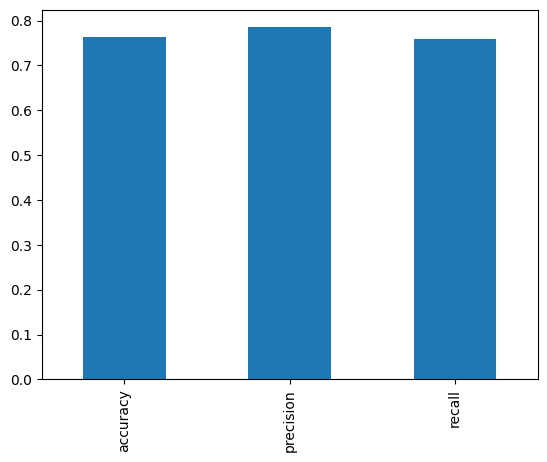

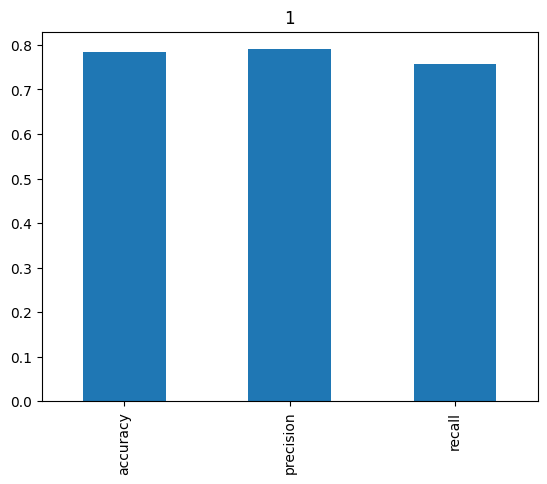

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define the metrics with an average method for multi-class classification
metrics_dict = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')
}

# Assuming `y_test`, `y_pred`, and `X_test['PTGENDER']` are defined as before

# Create a MetricFrame to analyze the model's performance across the groups defined by 'PTGENDER'
metric_frame = MetricFrame(
    metrics=metrics_dict,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['PTGENDER']
)

# Print the disaggregated metrics
print("Metrics by group:")
print(metric_frame.by_group)

# If you encounter issues with plotting directly from MetricFrame due to the layout parameter,
# you can plot each metric individually
for metric_name, metric_values in metric_frame.by_group.iterrows():
    metric_values.plot(kind='bar', title=metric_name)
    plt.show()


Interpreting the Results:

Accuracy: Shows how often the model predicts the correct label. A higher accuracy indicates better overall performance. Your model has slightly higher accuracy for PTGENDER 1 compared to 0.

Precision: Indicates the proportion of positive identifications that were actually correct. Higher precision means that when the model predicts a class, it is more likely to be correct. Precision is slightly higher for PTGENDER 1 than for 0, suggesting that the model is slightly more precise in its predictions for group 1.

Recall: Measures the proportion of actual positives that were identified correctly. It shows the model's ability to find all relevant instances in the dataset. The recall is quite similar across both groups, indicating that the model's ability to detect positive instances is fairly consistent across different genders.

In [ ]:
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame

# Predictions from the logistic regression model
y_pred_logreg = logreg.predict(X_test)

# Calculate accuracy for each group defined by the sensitive attribute
metric_frame_logreg = MetricFrame(
    metrics=accuracy_score,
    y_true=y_test,
    y_pred=y_pred_logreg,
    sensitive_features=X_test['PTGENDER']
)

# Display fairness metrics
print(metric_frame_logreg.by_group)

# Calculate and print the difference in accuracy between groups for fairness assessment
# Calculate and print the difference in accuracy between groups for fairness assessment
accuracy_diff = metric_frame_logreg.difference()
print(f"Accuracy difference between groups: {accuracy_diff}")


PTGENDER
0    0.763289
1    0.784044
Name: accuracy_score, dtype: float64
Accuracy difference between groups: 0.020754979961339348


Based on the results, the accuracy difference between the groups defined by PTGENDER is approximately 0.02075, or about 2.08%.

This suggests that there is a slight difference in model performance between the two gender groups, with group 1 having a slightly higher accuracy than group 0. While the difference is not large, it does indicate a potential bias in the model's predictions favoring one gender over the other.

# Comparison report of the three models — XGBoost (Baseline), Kaplan-Meier/Cox Proportional Hazards, and Logistic Regression —  Summarize each model's key aspects, including their purpose, methodology, and performance metrics, and then compare them across various parameters.

**XGBoost (Baseline):**
Purpose: To predict the diagnosis (DX) of Alzheimer's disease using features such as age, gender, education, genetic markers, and cognitive test scores.

**Methodology:**

Handled categorical variables via one-hot encoding.
Performed hyperparameter tuning using grid search to optimize the model.
Employed a robust ensemble learning method that uses gradient boosting.

**Performance:**

Accuracy: 88.64%
Precision: High across all classes (around 0.89 weighted average).
Recall: High across all classes (around 0.89 weighted average).
F1-Score: High across all classes (around 0.89 weighted average).
AUC-ROC: High for individual classes (0.98, 0.97, 0.95) with an average of 0.97.
Brier Score: 0.1738


**Kaplan-Meier/Cox Proportional Hazards:**
Purpose: To model the time to event data (survival analysis) in the context of Alzheimer's disease progression, not for direct diagnosis prediction.

**Methodology:**

Used the Kaplan-Meier estimator to generate survival curves.
Employed the Cox Proportional Hazards model to assess the impact of covariates on survival time.
Provided individual survival probabilities.

**Performance:**

Not directly comparable to the other models as it serves a different purpose (survival analysis vs. classification).
Concordance Index: 0.60, indicating moderate predictive power.
Hazard Ratios: Statistically significant for several covariates, indicating their impact on survival time.

**Logistic Regression:**

Purpose: To predict the diagnosis (DX) of Alzheimer's disease using the same features as the XGBoost model.

**Methodology:**

Utilized a simpler, more interpretable model compared to XGBoost.
Applied label encoding to transform categorical outcomes into a format suitable for logistic regression.

Used a linear approach to model the probabilities of the classes.

**Performance:**

Accuracy: 77.46%
Precision: Slightly lower than XGBoost (around 0.78 weighted average).
Recall: Slightly lower than XGBoost (around 0.77 weighted average).
F1-Score: Slightly lower than XGBoost (around 0.77 weighted average).
AUC-ROC: High for individual classes (0.89, 0.96, 0.84) with an average of 0.90.
Brier Score: 0.3316

**Comparative Analysis:**
Accuracy and Predictive Performance:

XGBoost outperforms logistic regression in terms of accuracy, precision, recall, and F1-score.

The Kaplan-Meier/Cox models are not directly comparable on these metrics as they are used for survival analysis rather than classification.

**Model Complexity and Interpretability:**

Logistic regression offers greater simplicity and interpretability, which may be advantageous in certain contexts where understanding the impact of individual features is important.
XGBoost, being a more complex model, may be harder to interpret but provides better performance.

**Applicability:**

XGBoost and logistic regression are suitable for predictive tasks where a direct diagnosis is required.

Kaplan-Meier and Cox models are more appropriate for survival analysis to understand the impact of different factors on the progression of Alzheimer's disease over time.

**AUC-ROC and Brier Score:**

XGBoost has the highest average AUC-ROC, indicating superior performance in distinguishing between different classes.

Logistic regression has a respectable AUC-ROC but a higher Brier score than XGBoost, suggesting that its probability estimates are less accurate.

**Conclusion:**

In the context of predicting Alzheimer's disease diagnosis, the XGBoost model demonstrates the best overall performance across multiple metrics, making it a strong candidate for tasks requiring high accuracy and discriminative ability. Logistic regression, while not as performant, offers a more straightforward and interpretable model, which could be preferred in scenarios where model complexity is a concern. The Kaplan-Meier and Cox Proportional Hazards models provide valuable insights for survival analysis and can complement the predictive models by offering a deeper understanding of the disease's progression over time.

# Comparison based on calibration plots for both the XGBoost and Logistic Regression models.

**XGBoost Model Calibration:**

The calibration seems to have significantly adjusted the probabilities towards the corners of the simplex, indicating increased confidence in class predictions.

Visualization: The dense cluster of arrows pointing up in the XGBoost plot suggests a considerable number of predictions have shifted towards higher confidence in Class 2 after calibration. The large red and blue dots at the corners suggest perfect confidence for Classes 1 and 3, respectively.

**Logistic Regression Model Calibration:**


 The calibration appears to have made the model's probability predictions more decisive, with many arrows pointing towards the vertices, suggesting an increased certainty in class predictions.

Visualization: The Logistic Regression calibration plot would likely show a similar trend as the XGBoost model if the arrows were shown, with adjustments pointing towards higher confidence in predictions.

**Comparative Analysis:**

Confidence in Predictions: Both models exhibit a post-calibration trend towards increased confidence in predictions, with probability estimates moving closer to the vertices of the simplex (representing a 100% prediction for one class).

Calibration Method: Both models used sigmoid calibration, a common approach for adjusting predicted probabilities to better match observed frequencies.
Class Distribution: The calibration process seems to affect the predictions for certain classes more than others. In the XGBoost model, there's a noticeable movement towards Class 2, which may suggest that the original model was under-predicting this class.

Probability Adjustment: The adjustments in probabilities due to calibration are substantial for both models, as evidenced by the length of the arrows in the XGBoost plot. Without seeing the arrows for the Logistic Regression plot, we can only assume a similar adjustment magnitude if the calibration was effective.

Calibration Needs: The necessity and degree of calibration suggest that both models might have initially been providing overconfident (near the edges) or underconfident (towards the center) probabilities, which the calibration process aimed to correct.

**Conclusion:**

Calibration has a pronounced effect on both the XGBoost and Logistic Regression models, pushing the probability estimates towards more decisive predictions. The plots indicate that the calibration method used has had the intended effect of adjusting probabilities towards what could be assumed to be a more accurate representation of the true class probabilities. However, without explicit pre-calibration plots or numerical metrics such as Brier score improvements, log loss, or a reliability diagram, the effectiveness of this calibration cannot be quantitatively assessed.

Both models seem to benefit from calibration, as is common with many machine learning models, especially those that output probabilities. The goal of calibration is to make the predicted probabilities more reflective of the true outcome probabilities, and the direction of the arrows in the XGBoost plot suggests that the calibration process is achieving this goal. For the Logistic Regression, one would expect a similar effect, but the absence of arrows in the provided plot means we cannot visually confirm this.